In [1]:
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import TensorBoardLogger
from skimage.metrics import peak_signal_noise_ratio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from src.forward_operator.operators import cfa_operator
from src.lightning_classes import UnrolledSystem, DataModule
from src.data_loader import RGBDataset, RGB_SPECTRAL_STENCIL

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CFA = 'bayer'
TRAIN_DIR = 'images/train'
VAL_DIR = 'images/val'
TEST_DIR = 'images/test'
SCALE = 2
NB_STAGES = 8
NB_CHANNELS = 32
KERNEL_SIZE = 3
BATCH_SIZE = 32
LEARNING_RATE = 1e-2
NB_EPOCHS = 100

OP = cfa_operator(CFA, [160, 240, 3], RGB_SPECTRAL_STENCIL, 'dirac')

In [3]:
train_dataset = RGBDataset(TRAIN_DIR, SCALE, OP.direct)
val_dataset = RGBDataset(VAL_DIR, SCALE, OP.direct)
test_dataset = RGBDataset(TEST_DIR, SCALE, OP.direct)

data_module = DataModule(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

model = UnrolledSystem(LEARNING_RATE, 'U_ADMM', NB_STAGES, CFA, RGB_SPECTRAL_STENCIL, NB_CHANNELS, KERNEL_SIZE)

In [4]:
logger = TensorBoardLogger('tb_logs', default_hp_metric=False)

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=50)
lr_monitor = LearningRateMonitor(logging_interval='epoch')
save_best = ModelCheckpoint(filename='best', monitor='val_loss')
trainer = pl.Trainer(max_epochs=NB_EPOCHS, callbacks=[early_stop, lr_monitor, save_best], logger=logger)

# tuner = Tuner(trainer)
# tuner.lr_find(model, datamodule=data_module)
# print(model.lr)
# tuner.scale_batch_size(model, datamodule=data_module, init_val=16)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
trainer.fit(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | U_ADMM | 1.8 K 
---------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


/home/mullemat/.pyenv/versions/torch/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 99: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s, v_num=1, val_loss=0.0116]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s, v_num=1, val_loss=0.0116]


In [6]:
trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


[{}]

In [9]:
model = UnrolledSystem.load_from_checkpoint(f'tb_logs/lightning_logs/version_1/checkpoints/best.ckpt')
model.eval()

img = Image.open('images/val/3096.jpg')
x = np.array(img.resize((img.size[0] // SCALE, img.size[1] // SCALE))) / 255
y = OP.direct(x)
x_baseline = OP.adjoint(y)
input_data = torch.tensor(y, dtype=torch.float, device=DEVICE)[None]

with torch.no_grad():
    x_hat = np.clip(model(input_data)[0].numpy(force=True).astype(float), 0, 1)

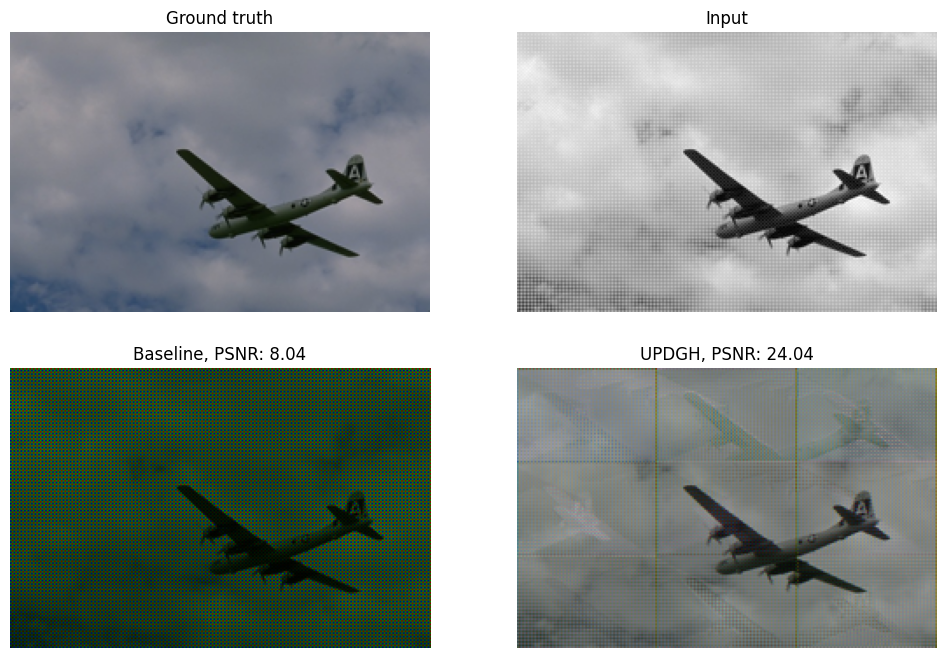

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].imshow(x)
axs[0, 0].set_title('Ground truth')
axs[0, 0].axis('off')
axs[0, 1].imshow(y, cmap='gray')
axs[0, 1].set_title('Input')
axs[0, 1].axis('off')
axs[1, 0].imshow(x_baseline)
axs[1, 0].set_title(f'Baseline, PSNR: {peak_signal_noise_ratio(x, x_baseline):.2f}')
axs[1, 0].axis('off')
axs[1, 1].imshow(x_hat)
axs[1, 1].set_title(f'UPDGH, PSNR: {peak_signal_noise_ratio(x, x_hat):.2f}')
axs[1, 1].axis('off')
plt.show()